#### 
![](微信截图_20200428083544.png)

In [1]:
import os

In [6]:
def png_jpg (directory):
    pngfiles = os.listdir(directory)
    for png in pngfiles:
        Olddir=os.path.join(directory,png)
        filename=os.path.splitext(png)[0]
        filetype=os.path.splitext(png)[1]
        newfiletype = filetype.replace('png','jpg')
        Newdir = os.path.join(directory,filename+newfiletype)
        os.rename(Olddir,Newdir)

In [7]:
png_jpg('E:/AAA_Study/202003_GraduationProject/Learning/images')

In [4]:
import os
import xml.etree.cElementTree as ET
import pandas as pd
import numpy as np
import xml.dom.minidom as xmldom

## 数据获取流程
### 1.先将pbf解压为osm，从osm文件提取university信息——工具：osmconvert、osmfilter（文件大小爆炸）

In [ ]:
#pbf转码为osm
def convert_pbf_osm (pbf_file) :
    base_path = 'E:/AAA_Study/202003_GraduationProject/'
    osmconvert_path = base_path + 'osmconvert'
    osm_file = pbf_file.replace('.osm.pbf','.osm')
    
    terminal_code = '{} {} > {}'.format(osmconvert_path,pbf_file,osm_file)
    os.system(terminal_code)
    print ('{} converted to {}'.format(pbf_file,osm_file))

In [ ]:
OSMPBF_PATH = "E:/AAA_Study/202003_GraduationProject/MapData/OSMData/sources/great_britain_latest.osm.pbf"
convert_pbf_osm(OSMPBF_PATH)

In [ ]:
#campus提取
def campus_extract(osmfilename):
    sel_osmkey = 'amenity'
    sel_osmvalue = ['university']
    country_name = os.path.split(osmfilename)[1]
    osmfilter_path = 'E:/AAA_Study/202003_GraduationProject/' + 'osmfilter'
    
    for value in sel_osmvalue:
        sel_element = sel_osmkey + "=" + value
        print (sel_element)
        output_sel = osmfilename.replace('.osm','_{}.osm'.format(value))
        print (output_sel)
        terminal_code = '{} {} --keep="{}" -o={}'.format(osmfilter_path,osmfilename,sel_element,output_sel)
        os.system(terminal_code)
    print(country_name + "----------" + sel_element + " extracted success!")
   

In [ ]:
OSM_PATH = "E:/AAA_Study/202003_GraduationProject/MapData/OSMData/sources/great_britain_latest.osm"
campus_extract(OSM_PATH)

### 2.筛除废数据，只提取“way”类型的数据，按照tag剔除“building”
### 3.筛数据的同时，保存获取每个campus轮廓的四边界和几何中心点信息

In [2]:
def count_tags(filename):
    osm = ET.ElementTree(file=filename)
    root = osm.getroot()
    tags_count_dic = {root.tag:0}
    for _,ele in ET.iterparse(filename,events=('start',)):
        if ele.tag in tags_count_dic:
            tags_count_dic[ele.tag] += 1
        else:
            tags_count_dic[ele.tag] = 1
    return tags_count_dic

In [3]:
OSM_PATH = 'E:/AAA_Study/202003_GraduationProject/MapData/OSMData/sources/great_britain_latest_university.osm'
count_tags(OSM_PATH)

{'osm': 1,
 'bounds': 1,
 'node': 32017,
 'tag': 10858,
 'way': 1489,
 'nd': 34677,
 'relation': 74,
 'member': 545}

In [58]:
#从osm文件中筛选可用的university campus的POI
def screenData (INPUT_OSM,OUTPUT_CSV):
    print('starting screening data...')
    dom = xmldom.parse(INPUT_OSM)
    element = dom.documentElement
    sub_element_n = element.getElementsByTagName("node")
    sub_element_w = element.getElementsByTagName("way")
    print('raw university data:' + str(len(sub_element_w)))

    campusDataStack = []
    
    for i in range(len(sub_element_w)):
        way_tags = sub_element_w[i].getElementsByTagName("tag")
        string = ''
        name = ''
        for j in range(len(way_tags)):    
            string = string + way_tags[j].getAttribute('k')+way_tags[j].getAttribute('v')
            if way_tags[j].getAttribute('k') == 'name':
                name = way_tags[j].getAttribute('v')
        if 'university' in string and 'building' not in string:
            temp_lat = []
            temp_lon = []
            way_nds = sub_element_w[i].getElementsByTagName("nd")

            for k in range(len(way_nds)):
                node_id = way_nds[k].getAttribute('ref')
                for m in range(len(sub_element_n)):
                    if sub_element_n[m].getAttribute('id') == node_id:
                        temp_lat.append(float(sub_element_n[m].getAttribute('lat')))
                        temp_lon.append(float(sub_element_n[m].getAttribute('lon')))

            campusDataStack.append([sub_element_w[i].getAttribute('id') , sum(temp_lat)/len(temp_lat) , sum(temp_lon)/len(temp_lon) , name,
                                    max(temp_lat),min(temp_lat),max(temp_lon),min(temp_lon)])
        print('\r'+ '{:0>4.1f}%'.format((i/len(sub_element_w)*100)),end='',flush=True)
            
    campusData = pd.DataFrame(campusDataStack,columns=['OSMID','center_lat','center_lon','name','north','south','east','west'])
    print('final university data:')
    print(campusData.shape)
    campusData.to_csv(OUTPUT_CSV,index=0,encoding='utf-8-sig')

In [59]:
INPUT_OSM = 'E:/AAA_Study/202003_GraduationProject/MapData/OSMData/sources/great_britain_latest_university.osm'
OUTPUT_CSV = 'E:/AAA_Study/202003_GraduationProject/MapData/OSMData/POI_extract_campus/great_britain_latest_university.csv'
screenData(INPUT_OSM,OUTPUT_CSV)

starting screening data...
raw university data:1489
99.9%final university data:
(703, 8)


### 4.根据每个campus的四边界，提取范围内全部建筑矢量和道路

In [1]:
import osmnx as ox
import csv
import time

In [2]:
#仿照osmnx里的方法写一个footprints_from_bbox
def plot_figure_ground_bbox(north,south,east,west,network_type='all_private', street_widths=None,
                       default_width=4, fig_length=5, edge_color='w',
                       bgcolor='#333333', smooth_joints=True, filename=None,
                       file_format='png', show=False, save=True, close=True,
                       dpi=100):
    G = ox.graph_from_bbox(north,south,east,west, network_type=network_type,
                             simplify=False, truncate_by_edge=True,clean_periphery=False)
    # if user did not pass in custom street widths, create a dict of default
    # values
    if street_widths is None:
        street_widths = {'footway' : 1.5,
                         'steps' : 1.5,
                         'pedestrian' : 1.5,
                         'service' : 1.5,
                         'path' : 1.5,
                         'track' : 1.5,
                         'motorway' : 6}
    # we need an undirected graph to find every edge incident to a node
    G_undir = G.to_undirected()
    # for each network edge, get a linewidth according to street type (the OSM
    # 'highway' value)
    edge_linewidths = []
    for _, _, data in G_undir.edges(keys=False, data=True):
        street_type = data['highway'][0] if isinstance(data['highway'], list) else data['highway']
        if street_type in street_widths:
            edge_linewidths.append(street_widths[street_type])
        else:
            edge_linewidths.append(default_width)

    if smooth_joints:
        # for each node, get a nodesize according to the narrowest incident edge
        node_widths = {}
        for node in G_undir.nodes():
            # first, identify all the highway types of this node's incident edges
            incident_edges_data = [G_undir.get_edge_data(node, neighbor) for neighbor in G_undir.neighbors(node)]
            edge_types = [data[0]['highway'] for data in incident_edges_data]
            if len(edge_types) < 1:
                # if node has no incident edges, make size zero
                node_widths[node] = 0
            else:
                # flatten the list of edge types
                edge_types_flat = []
                for et in edge_types:
                    if isinstance(et, list):
                        edge_types_flat.extend(et)
                    else:
                        edge_types_flat.append(et)

                # for each edge type in the flattened list, lookup the
                # corresponding width
                edge_widths = [street_widths[edge_type] if edge_type in street_widths else default_width for edge_type in edge_types_flat]

                # the node diameter will be the biggest of the edge widths, to make joints perfectly smooth
                # alternatively, use min (?) to pervent anything larger from extending past smallest street's line
                circle_diameter = max(edge_widths)

                # mpl circle marker sizes are in area, so it is the diameter
                # squared
                circle_area = circle_diameter ** 2
                node_widths[node] = circle_area

        # assign the node size to each node in the graph
        node_sizes = [node_widths[node] for node in G_undir.nodes()]
    else:
        node_sizes = 0
        
    bbox = (north,south,east,west)
    # plot the figure
    fig, ax = ox.plot_graph(G_undir, bbox=bbox, fig_height=fig_length,fig_width=fig_length,
                         margin=0, axis_off=True, equal_aspect=False,
                         bgcolor=bgcolor, node_size=node_sizes,
                         node_color=edge_color, edge_linewidth=edge_linewidths,
                         edge_color=edge_color, show=show, save=save,
                         close=close, filename=filename, file_format=file_format,
                         dpi=dpi)
    return fig, ax

In [3]:
#仿照osmnx里的方法写一个footprints_from_bbox
def footprints_from_bbox(north,south,east,west, footprint_type='building', retain_invalid=False,
                          custom_settings=None):

    return ox.create_footprints_gdf(north=north, south=south, east=east, west=west,
                                 footprint_type=footprint_type, retain_invalid=retain_invalid,
                                 custom_settings=custom_settings)

def saveCampusFootprintsNetworks(ID,north,south,east,west):
    gdf = footprints_from_bbox(north,south,east,west)
    if len(gdf) > 0:
#         with open('E:/AAA_Study/202003_GraduationProject/zbzCode/json/'+ID+'.json', 'w',encoding="utf-8") as f:
#             f.write(gdf.to_json())
        print(gdf.crs)
        gdf_proj = ox.project_gdf(gdf)
        fig1, ax1 = plot_figure_ground_bbox(north,south,east,west, save=False, show=True, close=True)
        fig, ax = ox.plot_footprints(gdf,fig=fig1,ax=ax1, color='moccasin',save=True,set_bounds=False, show=False, close=True,filename=ID,file_format='png', dpi=100)
        print (ID + ' fp num:' + str(len(gdf)) + ' saved')
    else:
        print("this campus has no footprints data , save failed")
#     areas = gdf_proj.area



+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs +type=crs


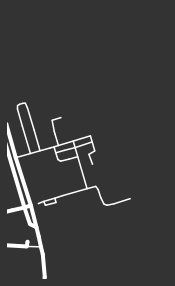

1 fp num:20 saved


KeyboardInterrupt: 

In [4]:
def test():
    starttime = time.time()
    CSV_FILE = 'E:/AAA_Study/202003_GraduationProject/MapData/OSMData/POI_extract_campus/test.csv'
    campus = []
    reader = csv.reader(open(CSV_FILE,encoding="utf-8"))
    for a, b, c, d, e, f, g, h in reader:
        colines = [a, e, f, g, h]  
        campus.append(colines)

    for i in range(len(campus)-1):
        saveCampusFootprintsNetworks(campus[i+1][0],float(campus[i+1][1]),float(campus[i+1][2]),float(campus[i+1][3]),float(campus[i+1][4]))
    endtime = time.time()
    print('---------------------------')
    print('total time:', round(endtime - starttime, 2),'secs')

test()


In [5]:

def make_plot(place, point, network_type='drive', bldg_color='orange', dpi=40,
              dist=805, default_width=4, street_widths=None):
    gdf = ox.footprints.footprints_from_point(point=point, distance=dist)
    fig, ax = ox.plot_figure_ground(point=point, dist=dist, network_type=network_type, default_width=default_width,
                                    street_widths=street_widths, save=False, show=False, close=True)
    fig, ax = ox.footprints.plot_footprints(gdf, fig=fig, ax=ax, color=bldg_color, set_bounds=False,
                                save=True, show=True, close=True, filename=place, dpi=dpi)

In [24]:
from IPython.display import Image

In [7]:
place = 'monrovia_liberia_buildings'
point = (6.340236, -10.747255)
make_plot(place, point, network_type='all', default_width=2, street_widths={'primary':6})

In [10]:
point = (21.0231,105.8531)
make_plot(place='a',point = point)